In [1]:
import os
import sys
import numpy as np
import torch as th
from motornet.policy import ModularPolicyGRU
from IPython.display import clear_output
import matplotlib.pyplot as plt
from typing import Any

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
print(root_directory)
sys.path.append(root_directory)

%load_ext autoreload
%autoreload 2

import motornet as mn

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

device = th.device("cpu")

saveLoc = '/Users/jonathanamichaels/Dropbox/torch/'
#saveLoc = '/media/jonathan/Data/Dropbox/torch/'

/Users/jonathanamichaels/Library/CloudStorage/Dropbox/mFiles-Projects/GitHub/MotorNet
All packages imported.
pytorch version: 2.2.0.dev20231011
numpy version: 1.25.2
motornet version: 0.2.0


In [2]:
class CSTask:
    def __init__(self, effector, **kwargs):
        self.effector = effector
        self.dt = self.effector.dt
        self.delay_range = [5000, 5000]  # this has to exist to get the size of the inputs
        self.base_joint = np.deg2rad([40., 80., 0., 0.]).astype(np.float32)
        self.base_cartesian = self.effector.joint2cartesian(th.tensor(self.base_joint)).to("cpu").numpy()

    def generate(self, batch_size, n_timesteps, **kwargs):
        targets = np.zeros(shape=(batch_size, n_timesteps, 1))
        inputs = np.zeros(shape=(batch_size, n_timesteps, 4))
        distances = np.zeros_like(targets)
        CST_chance = 0.75 # chance of CST trial vs RTT
        init_states = np.repeat(np.expand_dims(self.base_joint, axis=0), batch_size, axis=0)
        for i in range(batch_size):
            # Randomize initial hand state variability around zero to introduce deviation
            A = np.expand_dims(self.base_joint, axis=0)
            B = np.concatenate((np.random.uniform(low=-0.01, high=0.01, size=(1, 2)), np.zeros((1,2))), axis=1)
            init_states[i,:] = A + B       
        for i in range(batch_size):   
            if np.greater_equal(CST_chance, np.random.rand()):
                targets[i, :, 0] = 0
                inputs[i, :, 2] = 1.
                distances[i, :, 0] = 0.05
            else:
                last_switch = 0
                current_targ = 0.
                for j in range(n_timesteps):
                    last_switch += 1
                    # Switch current target with 1% probability each time step, provided the current target has been showing for at least 500ms
                    if np.greater_equal(0.01, np.random.rand()) and last_switch > 50:
                        current_targ = np.random.uniform(low=-0.05, high=0.05, size=1)
                        last_switch = 0
                    targets[i, j, 0] = current_targ
                inputs[i, :, 3] = 1.
                distances[i, :, 0] = 0.005
            
            # Shift visual info forward in time by 120ms to account for visual + screen delay
            inputs[i, 12:, 0] = targets[i, 0:-12, 0] * 10

            # Add a small amount of noise to visual feedback
            inputs[i, :, :] = inputs[i, :, :] + np.random.normal(loc=0., scale=1e-4,
                                                                 size=(inputs.shape[1], inputs.shape[2]))
        all_inputs = {"inputs": inputs, "distances": distances}
        return [all_inputs, targets, init_states]

In [3]:
class CSTaskEnv(mn.environment.Environment):
  def __init__(self, *args, **kwargs):
    # pass everything as-is to the parent Environment class
    super().__init__(*args, **kwargs)
    self.__name__ = "ExpTask"

  def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None):
    self._set_generator(seed)  # seed the environment and the effector

    options = {} if options is None else options
    batch_size: int = options.get("batch_size", 1)
    joint_state: th.Tensor | np.ndarray | None = options.get("joint_state", None)
    deterministic: bool = options.get("deterministic", False)

    self.effector.reset(options={"batch_size": batch_size, "joint_state": joint_state})
    self.elapsed = 0.
    action = th.zeros((batch_size, self.muscle.n_muscles)).to(self.device)
  
    self.obs_buffer["proprioception"] = [self.get_proprioception()] * len(self.obs_buffer["proprioception"])
    self.obs_buffer["vision"] = [self.get_vision()] * len(self.obs_buffer["vision"])
    self.obs_buffer["action"] = [action] * self.action_frame_stacking

    obs = self.get_obs(deterministic=deterministic)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": action,  # no noise here so it is the same
      }
    return obs, info

  def step(self, action, deterministic: bool = False, **kwargs):
    self.elapsed += self.dt

    if deterministic is False:
      noisy_action = self.apply_noise(action, noise=self.action_noise)
    else:
      noisy_action = action
    
    self.effector.step(noisy_action, **kwargs)

    obs = self.get_obs(action=noisy_action)
    reward = None
    truncated = False
    terminated = bool(self.elapsed >= self.max_ep_duration)
    info = {
      "states": self.states,
      "action": action,
      "noisy action": noisy_action,
      }
    return obs, reward, terminated, truncated, info

  def get_proprioception(self):
    mlen = self.states["muscle"][:, 1:2, :] / self.muscle.l0_ce
    mvel = self.states["muscle"][:, 2:3, :] / self.muscle.vmax
    prop = th.concatenate([mlen, mvel], dim=-1).squeeze(dim=1)
    return self.apply_noise(prop, self.proprioception_noise)

  def get_vision(self):
    vis = self.states["fingertip"]
    return self.apply_noise(vis, self.vision_noise)

  def get_obs(self, action=None, deterministic: bool = False):
    self.update_obs_buffer(action=action)

    obs_as_list = [
      self.obs_buffer["vision"][0],  # oldest element
      self.obs_buffer["proprioception"][0],   # oldest element
      ]
    obs = th.cat(obs_as_list, dim=-1)

    if deterministic is False:
       obs = self.apply_noise(obs, noise=self.obs_noise)
    return obs

dt = 0.01 # 10ms dt
ep_dur = 20.0
mm = mn.muscle.RigidTendonHillMuscle()
ee = mn.effector.RigidTendonArm26(muscle=mm, timestep=dt)
env = CSTaskEnv(max_ep_duration=ep_dur, effector=ee,
                     proprioception_delay=0.01, vision_delay=0.07,
                     proprioception_noise=1e-3, vision_noise=1e-3, action_noise=1e-4)

env.to(device)
print("Task subclass built.\n")

obs, info = env.reset()

print("obs shape:          ", obs.shape, end="\n\n\n")
for key, val in info.items():
  if type(val) is dict:
    print(key + ": ")
    for k, v in val.items():
      print("\t\t\t" + k + " shape:" + " " * (10-len(k)), v.shape)
  else:
    print(key + " shape:" + " " * (13-len(key)), val.shape)

Task subclass built.

obs shape:           torch.Size([1, 14])


states: 
			joint shape:      torch.Size([1, 4])
			cartesian shape:  torch.Size([1, 4])
			muscle shape:     torch.Size([1, 7, 6])
			geometry shape:   torch.Size([1, 4, 6])
			fingertip shape:  torch.Size([1, 2])
action shape:        torch.Size([1, 6])
noisy action shape:  torch.Size([1, 6])


In [4]:
n_t = int(ep_dur / env.effector.dt)
task = CSTask(effector=env.effector)
inputs, targets, init_states = task.generate(1, n_t)

In [5]:
# PMd, M1, Spinal
proportion_excitatory = None
c1 = 0.1
c2 = 0.05
c3 = 0.01
c0 = 0.5
vision_mask = [c0, 0, 0]
proprio_mask = [0, 0, c0]
task_mask = [c0, 0, 0]
connectivity_mask = np.array([[c0, c1, 0],
                              [c1, c0, c1],
                              [0, c1, c0]])
connectivity_delay = np.zeros_like(connectivity_mask)
output_mask = [0, 0, c0]
module_sizes = [128, 128, 16]
spectral_scaling = 1.
# input sparsity
vision_dim = np.arange(env.get_vision().shape[1])
proprio_dim = np.arange(env.get_proprioception().shape[1]) + vision_dim[-1] + 1
task_dim = np.arange(inputs['inputs'].shape[2]) + proprio_dim[-1] + 1
policy = ModularPolicyGRU(env.observation_space.shape[0] + inputs['inputs'].shape[2], module_sizes, env.n_muscles, 
                vision_dim=vision_dim, proprio_dim=proprio_dim, task_dim=task_dim, 
                vision_mask=vision_mask, proprio_mask=proprio_mask, task_mask=task_mask,
                connectivity_mask=connectivity_mask, output_mask=output_mask, connectivity_delay=connectivity_delay,
                proportion_excitatory=proportion_excitatory, input_gain=1,
                spectral_scaling=spectral_scaling, device=device, activation='tanh')
optimizer = th.optim.Adam(policy.parameters(), lr=3e-3)
scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9999)
#policy.load_state_dict(th.load(saveLoc + 'weights'))

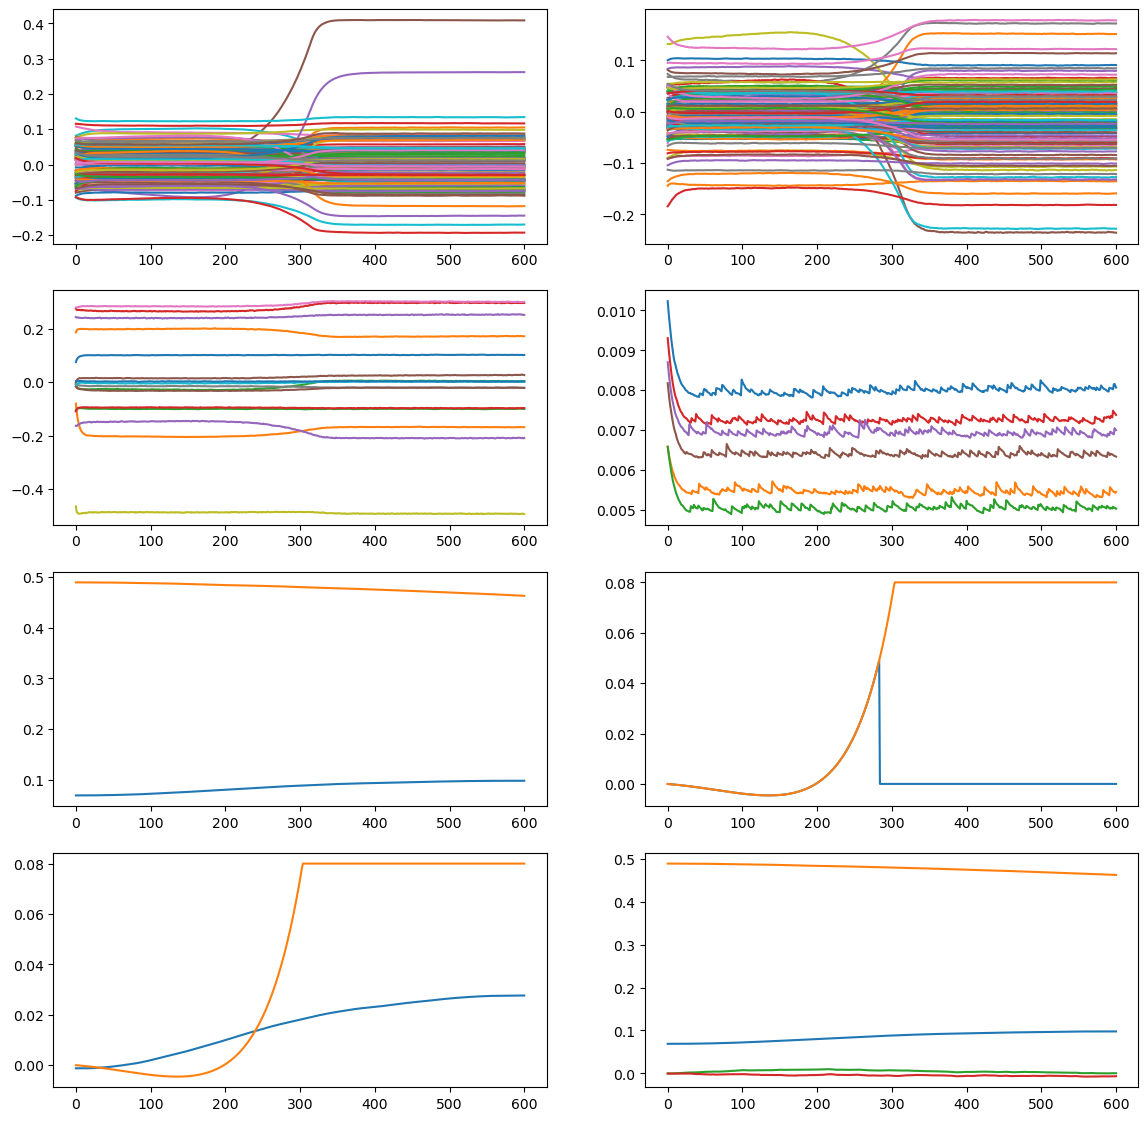

Cartesian:4.5664 Muscle:0.03725 Spectral:0.0044761 Activity:0.00153 Jerk:0.01866 Vertical:0.00000
Batch 550/5000 Done, total policy loss: 4.6283
6.0
[0.002838879773715641]
Cartesian:3.4761 Muscle:0.03727 Spectral:0.0043050 Activity:0.00141 Jerk:0.01872 Vertical:0.00000
Batch 551/5000 Done, total policy loss: 3.5378
6.0
[0.0028385958857382694]
Cartesian:5.4485 Muscle:0.03731 Spectral:0.0040695 Activity:0.00158 Jerk:0.01880 Vertical:0.00000
Batch 552/5000 Done, total policy loss: 5.5103
6.0
[0.0028383120261496956]
Cartesian:4.9741 Muscle:0.03738 Spectral:0.0033024 Activity:0.00155 Jerk:0.01893 Vertical:0.00000
Batch 553/5000 Done, total policy loss: 5.0353
6.0
[0.002838028194947081]
Cartesian:3.8229 Muscle:0.03737 Spectral:0.0029518 Activity:0.00142 Jerk:0.01892 Vertical:0.00000
Batch 554/5000 Done, total policy loss: 3.8836
6.0
[0.002837744392127586]
Cartesian:5.5273 Muscle:0.03742 Spectral:0.0044857 Activity:0.00164 Jerk:0.01902 Vertical:0.00000
Batch 555/5000 Done, total policy loss: 

In [ ]:
batch_size = 16
ep_dur = 6.
n_batch = 5000
losses = []
interval = 50

cursor_delay = 12
alpha_upper = 6.
lim = 0.08

for batch in range(n_batch):
  #if batch % 50 == 0 and batch != 0:
  #alpha_upper += 0.1
  print(alpha_upper)
  env.max_ep_duration = ep_dur
  n_t = int(ep_dur / env.effector.dt) + 1
  inputs, targets, init_states = task.generate(batch_size, n_t)
  target_size = th.tensor(np.tile(np.expand_dims(np.array(0.0), axis=(0,1,2)), [1, n_t, 2])).to(device)
  targets = th.tensor(targets, device=device, dtype=th.float)
  inp = th.tensor(inputs['inputs'], device=device, dtype=th.float)
  init_states = th.tensor(init_states, device=device, dtype=th.float)
  # initialize batch
  h = policy.init_hidden(batch_size)
  obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
  terminated = False
  
  # initial positions and targets
  all_xy = []
  all_cursor = []
  all_actions = []
  all_muscle = []
  all_hidden = []
  all_force = []
  all_targets = []
  all_inp = []
  all_joint = []
  
  cursor_offset = th.tensor(np.tile(task.base_cartesian[0][0], batch_size))
  cursor_state = th.zeros(batch_size)
  lbda = np.random.uniform(low=0.1, high=alpha_upper, size=batch_size)
  alpha = th.tensor(np.exp(lbda * env.dt))

  # simulate whole episode
  t_step = -1
  while not terminated:  # will run until `max_ep_duration` is reached
    t_step = int(t_step + 1)
    obs = th.concat((obs, inp[:,t_step,:]), dim=1)
    concat_hidden = th.cat((obs, h), dim=1)
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)
    
    cursor_state = (alpha * cursor_state) + ((alpha - 1) * (info['states']['cartesian'][:, 0] - cursor_offset))
    cursor_state = th.where(targets[:,-1,0] == 0, cursor_state, info['states']['cartesian'][:, 0] - cursor_offset)
    cursor_state = th.where(cursor_state > lim, lim, cursor_state)
    cursor_state = th.where(cursor_state < -lim, -lim, cursor_state)
    if t_step + cursor_delay < inp.shape[1]:
        inp[:, t_step + cursor_delay, 1] = (cursor_state * 10) + th.randn(cursor_state.shape, device=device) * 1e-4
    
    all_cursor.append(cursor_state[:, None, None]) 
    all_xy.append(info['states']['cartesian'][:, None, :])
    all_actions.append(action[:, None, :])
    all_muscle.append(info['states']['muscle'][:,0,None,:])
    all_force.append(info['states']['muscle'][:,-1,None,:])
    all_hidden.append(h[:,None,:])
    all_targets.append(th.unsqueeze(targets[:,t_step,:], dim=1))
    all_inp.append(th.unsqueeze(inp[:,t_step,:], dim=1))
    all_joint.append(info['states']['joint'][:, None, :])
    
  # concatenate into a (batch_size, n_timesteps, xy) tensor
  all_xy = th.cat(all_xy, axis=1)
  all_cursor = th.cat(all_cursor, axis=1)
  all_hidden = th.cat(all_hidden, axis=1)
  all_actions = th.cat(all_actions, axis=1)
  all_muscle = th.cat(all_muscle, axis=1)
  all_force = th.cat(all_force, axis=1)
  all_targets = th.cat(all_targets, axis=1)
  all_inp = th.cat(all_inp, axis=1)
  all_joint = th.cat(all_joint, axis=1)

  dist = th.abs(all_cursor - all_targets)
  all_targets = th.where(dist < th.tensor(inputs['distances']), all_cursor, all_targets)
  cartesian_loss = 1e2 * th.mean(th.sum(th.abs(all_cursor - all_targets), dim=-1)) # 1e2 best
  muscle_loss = 1e-3 * th.mean(th.sum(all_force, dim=-1)) # 1e-3 best
  activity_loss = 1e-3 * th.mean(th.sum(th.square(all_hidden), dim=-1)) # 1e-3 best
  spectral_loss = 1e-2 * th.mean(th.sum(th.square(th.diff(all_hidden, 1, dim=1) / th.pow(th.tensor(env.effector.dt), 1)), dim=-1)) # 1e-2 best
  jerk_loss = 1e-6 * th.mean(th.sum(th.square(all_force[:,:,2:]) / th.tensor(env.effector.dt), dim=-1)) # 1e-6 best
  vertical_loss = 0. * th.mean(th.abs(all_xy[:,:,1] - all_xy[:,0,1].unsqueeze(1).repeat([1, all_xy.shape[1]]))) # 1e-1 best
  loss = cartesian_loss + muscle_loss + spectral_loss + activity_loss + jerk_loss + vertical_loss
  
  # backward pass & update weights
  optimizer.zero_grad()
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())
  scheduler.step()
  print(scheduler.get_last_lr())

  obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
  
  if (batch % interval == 0):
      clear_output(wait=True)
      fg, ax = plt.subplots(nrows=4,ncols=2)
      fg.set_figwidth(14)
      fg.set_figheight(14)
      ind = 0
      ax[0,0].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[0]])))
      ax[0,1].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[1]])))
      ax[1,0].plot(np.transpose(np.squeeze(all_hidden.detach().cpu().numpy()[ind,:,policy.module_dims[2]])))
      ax[1,1].plot(np.squeeze(all_muscle.detach().cpu().numpy()[ind,:,:]))
      ax[2,0].plot(np.squeeze(all_xy.detach().cpu().numpy()[ind,:,0:2]))
      A = np.expand_dims(all_xy.detach().cpu().numpy()[ind,:,0] - cursor_offset.detach().cpu().numpy()[ind], axis=1)
      B = np.expand_dims(all_cursor.detach().cpu().numpy()[ind,:,0], axis=1)
      C = np.expand_dims(all_targets.detach().cpu().numpy()[ind,:,0], axis=1)
      ax[2,1].plot(np.concatenate((C,B), axis=1))    
      ax[3,0].plot(np.concatenate((A,B), axis=1))    
      ax[3,1].plot(np.squeeze(all_xy.detach().cpu().numpy()[ind,:,:]))
      #mn.plotor.plot_pos_over_time(xy[:,:,0:2].cpu().detach(), ax[5])
      plt.show()
      th.save(policy.state_dict(), saveLoc + 'weights_CST')
  print("Cartesian:{:.4f} Muscle:{:.5f} Spectral:{:.7f} Activity:{:.5f} Jerk:{:.5f} Vertical:{:.5f}".format(cartesian_loss.detach().cpu(), muscle_loss.detach().cpu(), spectral_loss.detach().cpu(), activity_loss.detach().cpu(), jerk_loss.detach().cpu(), vertical_loss.detach().cpu()))
  print("Batch {}/{} Done, total policy loss: {:.4f}".format(batch, n_batch, losses[-1]))

In [ ]:
batch_size = 3000
ep_dur = 6.
n_batch = 1
interval = 50

cursor_delay = 12
alpha_upper = 6.
lim = 0.08

for batch in range(n_batch):
  if batch % 100 == 0 and batch != 0:
  #  ep_dur += 1.
    alpha_upper += 0.1
  print(alpha_upper)
  env.max_ep_duration = ep_dur
  n_t = int(ep_dur / env.effector.dt) + 1
  inputs, targets, init_states = task.generate(batch_size, n_t)
  target_size = th.tensor(np.tile(np.expand_dims(np.array(0.0), axis=(0,1,2)), [1, n_t, 2])).to(device)
  targets = th.tensor(targets, device=device, dtype=th.float)
  inp = th.tensor(inputs['inputs'], device=device, dtype=th.float)
  init_states = th.tensor(init_states, device=device, dtype=th.float)
  # initialize batch
  h = policy.init_hidden(batch_size)
  obs, info = env.reset(options={'batch_size': batch_size, 'joint_state': init_states})
  terminated = False
  
  # initial positions and targets
  all_xy = []
  all_cursor = []
  all_actions = []
  all_muscle = []
  all_hidden = []
  all_force = []
  all_targets = []
  all_inp = []
  all_joint = []
  
  cursor_offset = th.tensor(np.tile(task.base_cartesian[0][0], batch_size))
  cursor_state = th.zeros(batch_size)
  lbda = np.random.uniform(low=0.1, high=alpha_upper, size=batch_size)
  alpha = th.tensor(np.exp(lbda * env.dt))

  # simulate whole episode
  t_step = -1
  while not terminated:  # will run until `max_ep_duration` is reached
    t_step = int(t_step + 1)
    obs = th.concat((obs, inp[:,t_step,:]), dim=1)
    h = h + th.randn(h.shape, device=device) * 1e-3 # 1e-3 best
    concat_hidden = th.cat((obs, h), dim=1)
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)
  
    cursor_state = (alpha * cursor_state) + ((alpha - 1) * (info['states']['cartesian'][:, 0] - cursor_offset))
    cursor_state = th.where(targets[:,-1,0] == 0, cursor_state, info['states']['cartesian'][:, 0] - cursor_offset)
    cursor_state = th.where(cursor_state > lim, lim, cursor_state)
    cursor_state = th.where(cursor_state < -lim, -lim, cursor_state)
    if t_step + cursor_delay < inp.shape[1]:
        inp[:, t_step + cursor_delay, 1] = (cursor_state * 10) + th.randn(cursor_state.shape, device=device) * 1e-4
    
    all_cursor.append(cursor_state[:, None, None]) 
    all_xy.append(info['states']['cartesian'][:, None, :])
    all_actions.append(action[:, None, :])
    all_muscle.append(info['states']['muscle'][:,0,None,:])
    all_force.append(info['states']['muscle'][:,-1,None,:])
    all_hidden.append(h[:,None,:])
    all_targets.append(th.unsqueeze(targets[:,t_step,:], dim=1))
    all_inp.append(th.unsqueeze(inp[:,t_step,:], dim=1))
    all_joint.append(info['states']['joint'][:, None, :])
    
  # concatenate into a (batch_size, n_timesteps, xy) tensor
  all_xy = th.cat(all_xy, axis=1)
  all_cursor = th.cat(all_cursor, axis=1)
  all_hidden = th.cat(all_hidden, axis=1)
  all_actions = th.cat(all_actions, axis=1)
  all_muscle = th.cat(all_muscle, axis=1)
  all_force = th.cat(all_force, axis=1)
  all_targets = th.cat(all_targets, axis=1)
  all_inp = th.cat(all_inp, axis=1)
  all_joint = th.cat(all_joint, axis=1)

  dist = th.abs(all_cursor - all_targets)
  all_targets = th.where(dist < 0.005, all_cursor, all_targets)

In [ ]:
import scipy.io
toSave = {'joint': all_joint.detach().numpy(),
                          'cartesian': all_xy.detach().numpy(),
                          'cursor': all_cursor.detach().numpy(),
                          'muscle': all_muscle.detach().numpy(),
                          'inputs': all_inp.detach().cpu().numpy(),
                          'targets': targets.detach().numpy(),
                          'neural': all_hidden.detach().numpy(),
                          'module_dims': policy.module_dims,
                          'lambda': lbda,
                          'cursor_offset': cursor_offset.detach().numpy(),
                          'losses': losses}
scipy.io.savemat(saveLoc + 'results_CST.mat', toSave)
th.save(policy.state_dict(), saveLoc + 'weights')

In [ ]:
inputs['inputs'].shape
ii = 0
fg, ax = plt.subplots(nrows=3,ncols=1)
ax[0].plot(inputs['inputs'][ii,:,:])
ax[2].plot(targets[ii,:,:])

In [ ]:
ii = 3
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(np.concatenate((targets.detach().cpu().numpy()[ii,:,:], all_xy.detach().cpu().numpy()[ii,:,0:2]), axis=1))

In [ ]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  #axs.semilogy(log)
  axs.plot(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

In [ ]:
ii = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
ax[0].plot(all_muscle.detach().cpu().numpy()[ii,:,:])
ax[1].plot(all_muscle.detach().cpu().numpy()[ii+1,:,:])

In [ ]:
ii = 0
m = 0
fg, ax = plt.subplots(nrows=2,ncols=1)
h = np.squeeze(all_hidden.detach().cpu().numpy()[ii : ii+2,:,policy.module_dims[m]])
ax[0].plot(h[0,:,:])
ax[1].plot(h[1,:,:])
print(h.shape)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(policy.mask_Wr.detach().cpu().numpy(), aspect='equal', interpolation='none', cmap=plt.cm.Greys)
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
Wh = policy.Wh.detach().cpu().numpy()[:,task_dim[-1]+1:]
plt.imshow(Wh, aspect='equal', interpolation='none', cmap=plt.cm.spring)
plt.show()
plt.figure(figsize=(6,4))
E = th.linalg.eigvals(th.Tensor(Wh)).detach().numpy()
plt.scatter(np.real(E), np.imag(E))
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
Wr = policy.Wr.detach().cpu().numpy()
plt.imshow(Wr, aspect='equal', interpolation='none')
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(policy.Wz.detach().cpu().numpy(), aspect='equal', interpolation='none')
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(policy.Y.detach().cpu().numpy(), aspect='auto', interpolation='none')
plt.show()

In [ ]:
import qspems

In [ ]:
N = np.transpose(all_hidden.detach().numpy(), axes=[2, 1, 0])
N = np.reshape(N, (N.shape[0], -1))
print(N.shape)
A1 = qspems.inf_via_LCCF(N, 15000, max_lag=1)
A2 = qspems.inf_via_LCRC(N, 15000, max_lag=1)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(A2, aspect='equal', interpolation='none', cmap=plt.cm.Greys)
plt.colorbar()
plt.show()
